# Title: Severity of road traffic accidents

In [1]:
%load_ext watermark
%watermark -a "Van Wu" -u -d -t -v -p numpy,pandas,matplotlib,scikit-learn

Author: Van Wu

Last updated: 2025-04-17 22:07:24

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

numpy       : 2.2.4
pandas      : 2.2.3
matplotlib  : 3.10.1
scikit-learn: 1.6.1



## Preparation

- [Github link](https://github.com/Van-Wu1/0006.git)

- Number of words: ***

- Runtime: *** hours (*Memory 32 GB, CPU AMD Ryzen 7 5800H with Radeon Graphics CPU @3.20GHz*)

- Coding environment: Coding environment: VS Code with Jupyter plugin (local), not SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.(used to print Python and package versions for reproducibility.)
    - ......

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

## Research questions

[[ go back to the top ]](#Table-of-contents)

## Data

[[ go back to the top ]](#Table-of-contents)

### 1. Data Description

| Variable                                  | Type         | Description                                                                                  | Notes                        |
|-------------------------------------------|--------------|----------------------------------------------------------------------------------------------|------------------------------|
| accident_severity                       | Categorical  | Severity level of the accident (e.g., slight, serious, fatal)                                | Target variable              |
| number_of_vehicles                      | Numeric      | Number of vehicles involved in the accident                                                  | -                            |
| number_of_casualties                    | Numeric      | Number of casualties involved                                                                | -                            |
| day_of_week                             | Categorical  | Day of the week when the accident occurred (1 = Sunday, ..., 7 = Saturday)                   | One-hot encoding recommended |
| time_hour (derived from time)         | Numeric      | Hour of the day when the accident occurred (e.g., 13:55 → 13)                                | Derived feature              |
| first_road_class                        | Categorical  | Classification of the primary road (1–6, denoting different road types)                      | Ordinal/Categorical          |
| second_road_class                       | Categorical  | Classification of the secondary road                                                         | -                            |
| road_type                               | Categorical  | Type of road (e.g., one-way, dual carriageway, roundabout)                                   | One-hot encoding             |
| speed_limit                             | Numeric      | Speed limit of the road segment (in mph)                                                     | -                            |
| junction_detail                         | Categorical  | Structural detail of the junction                                                            | -                            |
| junction_control                        | Categorical  | Type of junction control (e.g., traffic signal, give way sign)                               | -                            |
| pedestrian_crossing_human_control       | Categorical  | Presence of human-controlled pedestrian crossing                                             | Binary/Categorical           |
| pedestrian_crossing_physical_facilities | Categorical  | Presence of physical pedestrian crossing facilities (e.g., zebra crossing)                   | -                            |
| light_conditions                        | Categorical  | Lighting conditions at the time of the accident                                              | -                            |
| weather_conditions                      | Categorical  | Weather conditions during the accident (e.g., fine, rain, fog)                               | -                            |
| road_surface_conditions                 | Categorical  | Road surface conditions (e.g., dry, wet, icy)                                                | -                            |
| special_conditions_at_site              | Categorical  | Special conditions at the accident site (e.g., roadworks, closure)                           | -                            |
| carriageway_hazards                     | Categorical  | Presence of carriageway hazards (e.g., spillages, obstructions)                              | -                            |
| urban_or_rural_area                     | Categorical  | Whether the area is urban or rural (1 = Urban, 2 = Rural)                                    | Binary (urban = 1)           |
| did_police_officer_attend_scene_of_accident | Categorical  | Whether a police officer attended the scene of the accident                                  | Binary                       |
| trunk_road_flag                         | Categorical  | Whether the accident occurred on a trunk road                                                | Binary                       |
| local_authority_ons_district            | Categorical  | ONS code of the local authority district; useful for spatial join with external datasets     | Useful for joining external data |
| max_betweenness                          | Numeric      | Maximum betweenness centrality of road segments near the accident location                   | Network-based spatial feature |
| ......  | ......  | ......                                    |   |


### 2. Data Import and Prepration

In [2]:
# It would import the packages that would be used first. 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import osmnx as ox
import networkx as nx
import geopandas as gpd
from tqdm import tqdm

input_folder = '../data/raw'
output_folder = '../data/clean'

In [3]:
# Road Data
columns_to_keep = [
    'accident_severity',
    'number_of_vehicles',
    'number_of_casualties',
    'day_of_week',
    'time',
    'first_road_class',
    'second_road_class',
    'road_type',
    'speed_limit',
    'junction_detail',
    'junction_control',
    'pedestrian_crossing_human_control',
    'pedestrian_crossing_physical_facilities',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'special_conditions_at_site',
    'carriageway_hazards',
    'urban_or_rural_area',
    'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag',
    'local_authority_ons_district'
]

files = {
    '2019.csv': '2019_cleaned.csv',
    '2020.csv': '2020_cleaned.csv',
    '2021.csv': '2021_cleaned.csv',
    '2022.csv': '2022_cleaned.csv',
    '2023.csv': '2023_cleaned.csv'
    # '2024_unvalidated.csv': '2024_cleaned.csv'
}

for input_file, output_file in files.items():
    input_path = os.path.join(input_folder, input_file)
    df = pd.read_csv(input_path)

    selected_columns = [col for col in columns_to_keep if col in df.columns]
    df_cleaned = df[selected_columns]

    # ✅ 检查缺失值
    missing_counts = df_cleaned.isnull().sum()
    total_missing = missing_counts.sum()

    if total_missing > 0:
        print(f"⚠️  {output_file} has {total_missing} missing values:")
        print(missing_counts[missing_counts > 0])
        
        # 自动丢弃含缺失值的行
        # df_cleaned = df_cleaned.dropna()
        # print(f"✅ Dropped rows with missing values. Remaining rows: {len(df_cleaned)}")

    output_path = os.path.join(output_folder, output_file)
    df_cleaned.to_csv(output_path, index=False)
    print(f"✅ {output_file} has been saved in {output_path}, containing {len(df_cleaned.columns)} fields, for {len(df_cleaned)} records.\n")


df_2019 = pd.read_csv('../data/clean/2019_cleaned.csv')
df_2020 = pd.read_csv('../data/clean/2020_cleaned.csv')
df_2021 = pd.read_csv('../data/clean/2021_cleaned.csv')
df_2022 = pd.read_csv('../data/clean/2022_cleaned.csv')
df_2023 = pd.read_csv('../data/clean/2023_cleaned.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8224\3749200897.py:38: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2019_cleaned.csv has been saved in ../data/clean\2019_cleaned.csv, containing 22 fields, for 117536 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8224\3749200897.py:38: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2020_cleaned.csv has been saved in ../data/clean\2020_cleaned.csv, containing 22 fields, for 91199 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8224\3749200897.py:38: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2021_cleaned.csv has been saved in ../data/clean\2021_cleaned.csv, containing 22 fields, for 101087 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8224\3749200897.py:38: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2022_cleaned.csv has been saved in ../data/clean\2022_cleaned.csv, containing 22 fields, for 106004 records.



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8224\3749200897.py:38: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


✅ 2023_cleaned.csv has been saved in ../data/clean\2023_cleaned.csv, containing 22 fields, for 104258 records.



In [4]:
# RoadCentrality
path = "../data/Borough_Boundaries.geojson"
boroughs = gpd.read_file(path)
boroughs = boroughs[["name", "gss_code", "geometry"]].rename(columns={"name": "borough"})

ox.settings.log_console = False
ox.settings.use_cache = True

results = []

for idx, row in tqdm(boroughs.iterrows(), total=len(boroughs), desc="Processing boroughs"):
    borough_name = row["borough"]
    gss_name = row["gss_code"]   
    geometry = row["geometry"]

    try:
        print(f"🚦 Processing: {borough_name}")
        
        G = ox.graph_from_polygon(geometry, network_type="drive", simplify=True)

        betweenness = nx.betweenness_centrality(G, weight="length", k=100, seed=42)
        degree = dict(G.degree())
        nx.set_node_attributes(G, betweenness, "betweenness")
        nx.set_node_attributes(G, degree, "degree")

        edge_data = []
        for u, v, key, data in G.edges(keys=True, data=True):
            edge_data.append({
                "u": u,
                "v": v,
                "key": key,
                "geometry": data.get("geometry", None),
                "betweenness": (G.nodes[u]["betweenness"] + G.nodes[v]["betweenness"]) / 2,
                "degree": (G.nodes[u]["degree"] + G.nodes[v]["degree"]) / 2
            })
        edges_df = gpd.GeoDataFrame(edge_data, geometry="geometry", crs="EPSG:4326")

        summary = {
            "borough": borough_name,
            "gss_code": gss_name,
            "mean_betweenness": edges_df["betweenness"].mean(),
            "max_betweenness": edges_df["betweenness"].max(),
            "mean_degree": edges_df["degree"].mean(),
            "max_degree": edges_df["degree"].max(),
            "edge_count": len(edges_df)
        }
        results.append(summary)

    except Exception as e:
        print(f"❌ Failed for {borough_name}: {e}")
        continue

df_results = pd.DataFrame(results)
df_results.to_csv("../data/london_borough_road_centrality.csv", index=False)
print("All done! Results saved to 'london_borough_road_centrality.csv'")

Processing boroughs:   0%|          | 0/33 [00:00<?, ?it/s]

🚦 Processing: Kingston upon Thames


Processing boroughs:   3%|▎         | 1/33 [00:05<02:41,  5.06s/it]

🚦 Processing: Croydon


Processing boroughs:   6%|▌         | 2/33 [00:18<05:01,  9.72s/it]

🚦 Processing: Bromley


Processing boroughs:   9%|▉         | 3/33 [00:32<05:52, 11.74s/it]

🚦 Processing: Hounslow


Processing boroughs:  12%|█▏        | 4/33 [00:40<05:05, 10.53s/it]

🚦 Processing: Ealing


Processing boroughs:  15%|█▌        | 5/33 [00:50<04:49, 10.32s/it]

🚦 Processing: Havering


Processing boroughs:  18%|█▊        | 6/33 [00:59<04:21,  9.70s/it]

🚦 Processing: Hillingdon


Processing boroughs:  21%|██        | 7/33 [01:11<04:29, 10.36s/it]

🚦 Processing: Harrow


Processing boroughs:  24%|██▍       | 8/33 [01:17<03:46,  9.07s/it]

🚦 Processing: Brent


Processing boroughs:  27%|██▋       | 9/33 [01:24<03:21,  8.39s/it]

🚦 Processing: Barnet


Processing boroughs:  30%|███       | 10/33 [01:35<03:32,  9.22s/it]

🚦 Processing: Lambeth


Processing boroughs:  33%|███▎      | 11/33 [01:43<03:16,  8.93s/it]

🚦 Processing: Southwark


Processing boroughs:  36%|███▋      | 12/33 [01:52<03:06,  8.87s/it]

🚦 Processing: Lewisham


Processing boroughs:  39%|███▉      | 13/33 [02:00<02:51,  8.56s/it]

🚦 Processing: Greenwich


Processing boroughs:  42%|████▏     | 14/33 [02:10<02:50,  8.99s/it]

🚦 Processing: Bexley


Processing boroughs:  45%|████▌     | 15/33 [02:18<02:37,  8.75s/it]

🚦 Processing: Enfield


Processing boroughs:  48%|████▊     | 16/33 [02:28<02:33,  9.02s/it]

🚦 Processing: Waltham Forest


Processing boroughs:  52%|█████▏    | 17/33 [02:34<02:11,  8.23s/it]

🚦 Processing: Redbridge


Processing boroughs:  55%|█████▍    | 18/33 [02:41<01:59,  7.97s/it]

🚦 Processing: Sutton


Processing boroughs:  58%|█████▊    | 19/33 [02:48<01:45,  7.55s/it]

🚦 Processing: Richmond upon Thames


Processing boroughs:  61%|██████    | 20/33 [02:55<01:36,  7.42s/it]

🚦 Processing: Merton


Processing boroughs:  64%|██████▎   | 21/33 [03:01<01:24,  7.07s/it]

🚦 Processing: Wandsworth


Processing boroughs:  67%|██████▋   | 22/33 [03:10<01:22,  7.47s/it]

🚦 Processing: Hammersmith and Fulham


Processing boroughs:  70%|██████▉   | 23/33 [03:13<01:03,  6.35s/it]

🚦 Processing: Kensington and Chelsea


Processing boroughs:  73%|███████▎  | 24/33 [03:17<00:49,  5.48s/it]

🚦 Processing: Westminster


Processing boroughs:  76%|███████▌  | 25/33 [03:23<00:46,  5.77s/it]

🚦 Processing: Camden


Processing boroughs:  79%|███████▉  | 26/33 [03:29<00:39,  5.66s/it]

🚦 Processing: Tower Hamlets


Processing boroughs:  82%|████████▏ | 27/33 [03:35<00:35,  5.94s/it]

🚦 Processing: Islington


Processing boroughs:  85%|████████▍ | 28/33 [03:40<00:28,  5.61s/it]

🚦 Processing: Hackney


Processing boroughs:  88%|████████▊ | 29/33 [03:45<00:21,  5.47s/it]

🚦 Processing: Haringey


Processing boroughs:  91%|█████████ | 30/33 [03:51<00:16,  5.54s/it]

🚦 Processing: Newham


Processing boroughs:  94%|█████████▍| 31/33 [03:59<00:12,  6.28s/it]

🚦 Processing: Barking and Dagenham


Processing boroughs:  97%|█████████▋| 32/33 [04:04<00:05,  5.90s/it]

🚦 Processing: City of London


Processing boroughs: 100%|██████████| 33/33 [04:06<00:00,  7.46s/it]

All done! Results saved to 'london_borough_road_centrality.csv'


In [5]:
#Join
# 设置路径
accident_folder = "../data/clean"
centrality_path = "../data/london_borough_road_centrality.csv"
data_with_centrality = "../data/final"

# 读取道路中心性数据
df_centrality = pd.read_csv(centrality_path)

# 循环处理每一年
for year in range(2019, 2024):  # 2019–2023
    accident_file = f"{year}_cleaned.csv"
    accident_path = os.path.join(accident_folder, accident_file)

    if not os.path.exists(accident_path):
        print(f"❌ File not found: {accident_path}")
        continue

    # 读取事故数据
    df_accident = pd.read_csv(accident_path)

    # 合并中心性数据
    df_merged = df_accident.merge(
        df_centrality,
        how="left",
        left_on="local_authority_ons_district",
        right_on="gss_code"
    )

    # 删除没有中心性值的行（非伦敦地区）
    before_drop = len(df_merged)
    df_merged = df_merged.dropna(subset=["mean_betweenness"])
    after_drop = len(df_merged)
    dropped = before_drop - after_drop

    # 输出文件
    output_path = os.path.join(data_with_centrality, f"{year}_with_centrality.csv")
    df_merged.to_csv(output_path, index=False)

    print(f"✅ {year} saved with centrality! Rows kept: {after_drop}, dropped: {dropped}")

✅ 2019 saved with centrality! Rows kept: 25310, dropped: 92226
✅ 2020 saved with centrality! Rows kept: 20996, dropped: 70203
✅ 2021 saved with centrality! Rows kept: 23127, dropped: 77960
✅ 2022 saved with centrality! Rows kept: 23477, dropped: 82527
✅ 2023 saved with centrality! Rows kept: 22895, dropped: 81363


In [6]:
import pandas as pd
import os

# 定义年份和路径
years = [2019, 2020, 2021, 2022, 2023]
dfs = []

for year in years:
    path = f"../data/final/{year}_with_centrality.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["year"] = year  # ✅ 添加年份列
        dfs.append(df)
    else:
        print(f"❌ File not found: {path}")

# 合并所有年份数据
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv("../data/final/all_years_with_centrality.csv", index=False)


### 3. Data Pattern Analysis

In [7]:
df = df_all

In [8]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())   # 缺失值检查
df.describe()              # 数值特征统计
df["accident_severity"].value_counts(normalize=True)  # 类别分布

(115805, 30)
accident_severity                                int64
number_of_vehicles                               int64
number_of_casualties                             int64
day_of_week                                      int64
time                                            object
first_road_class                                 int64
second_road_class                                int64
road_type                                        int64
speed_limit                                      int64
junction_detail                                  int64
junction_control                                 int64
pedestrian_crossing_human_control                int64
pedestrian_crossing_physical_facilities          int64
light_conditions                                 int64
weather_conditions                               int64
road_surface_conditions                          int64
special_conditions_at_site                       int64
carriageway_hazards                              int

accident_severity
3    0.847796
2    0.147982
1    0.004223
Name: proportion, dtype: float64

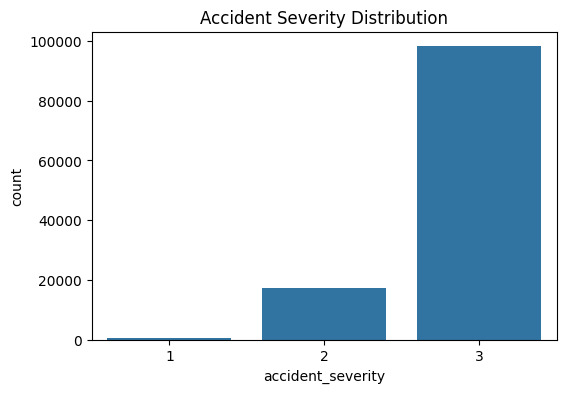

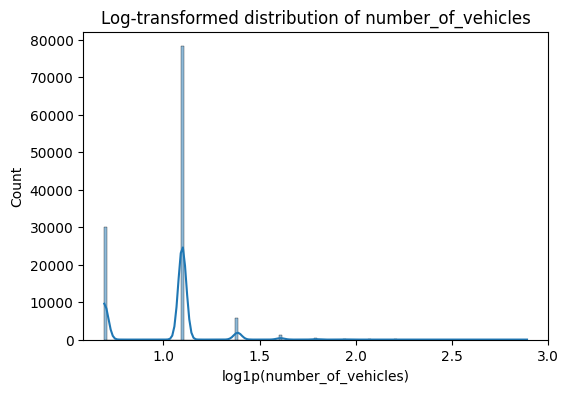

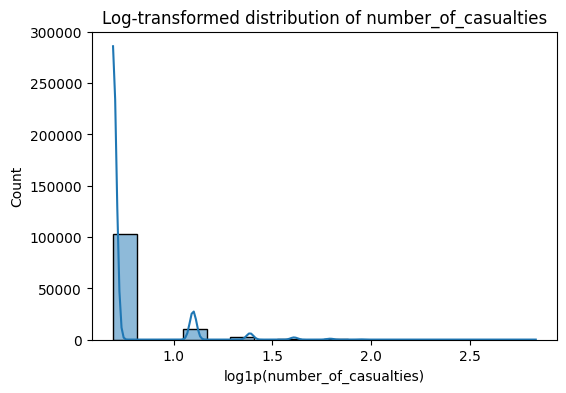

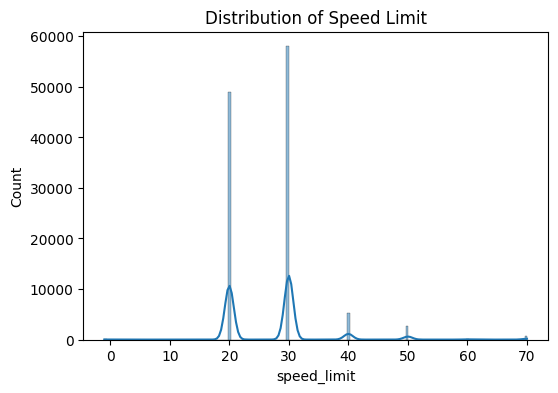

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 事故严重程度分布
plt.figure(figsize=(6,4))
sns.countplot(x="accident_severity", data=df)
plt.title("Accident Severity Distribution")
plt.show()


# 数值型：车数、伤亡数、限速
for col in ["number_of_vehicles", "number_of_casualties"]:
    plt.figure(figsize=(6, 4))
    sns.histplot(np.log1p(df[col]), kde=True)  # log1p(x) = log(x + 1)，避免 log(0) 报错
    plt.title(f"Log-transformed distribution of {col}")
    plt.xlabel(f"log1p({col})")
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df["speed_limit"], kde=True)
plt.title("Distribution of Speed Limit")
plt.xlabel("speed_limit")
plt.ylabel("Count")
plt.show()


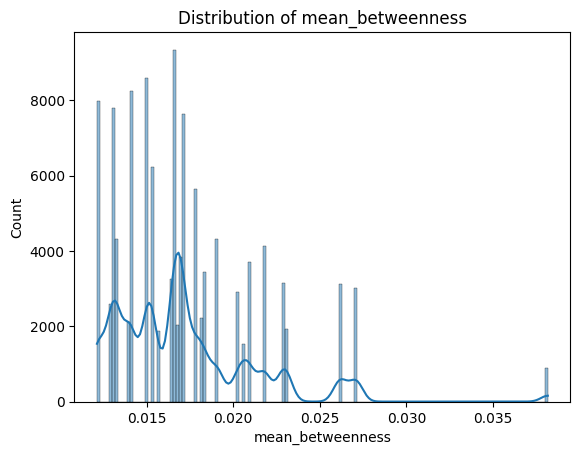

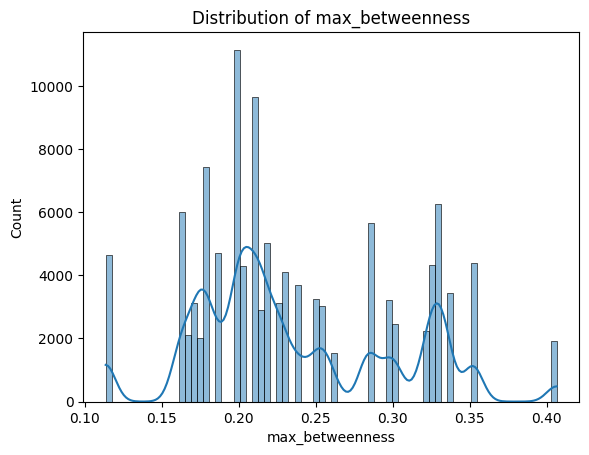

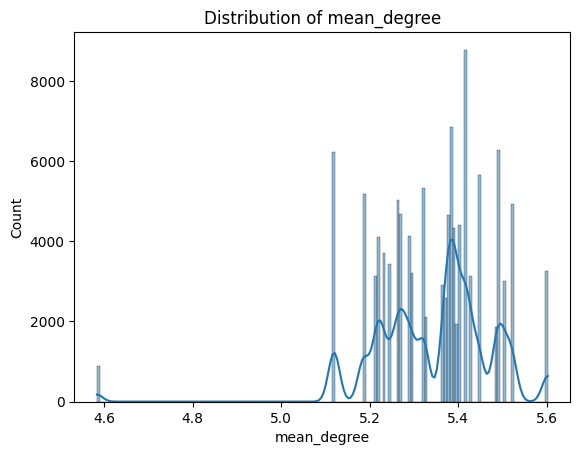

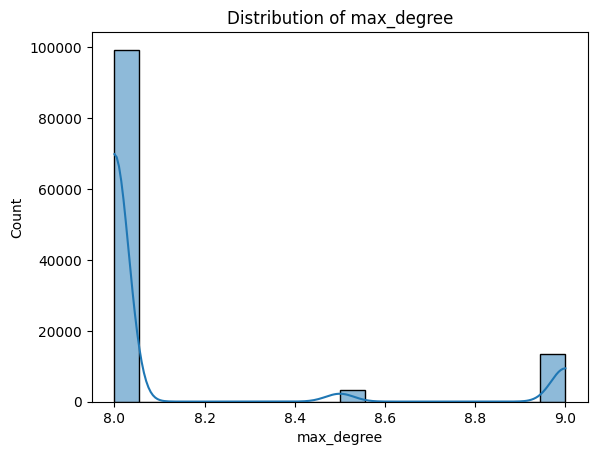

In [10]:
# 中心性变量分布（单变量 + 空值检查）
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

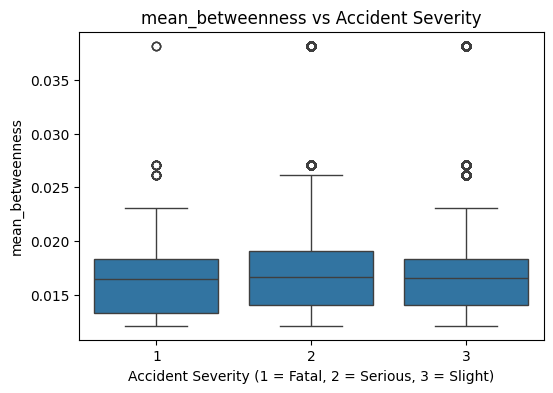

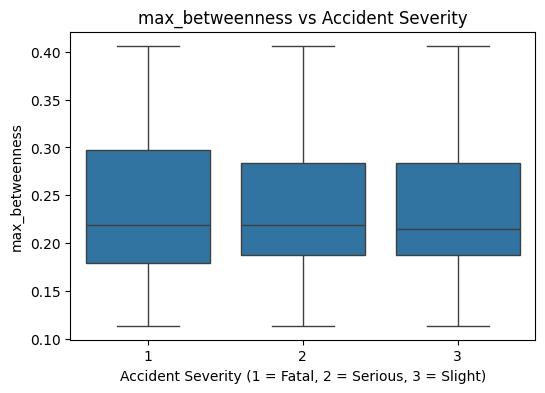

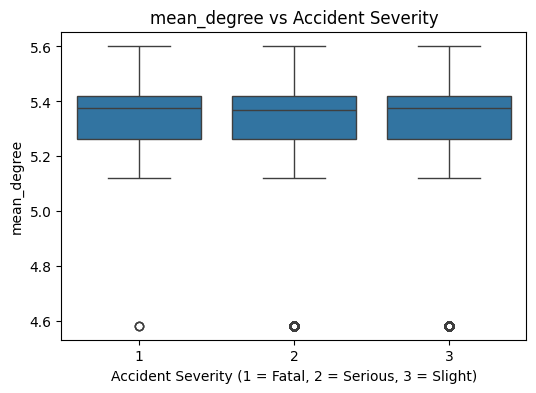

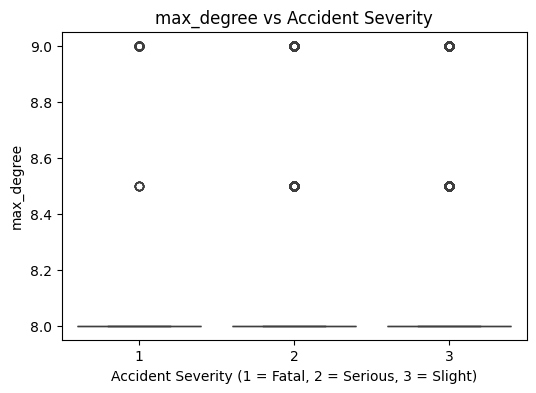

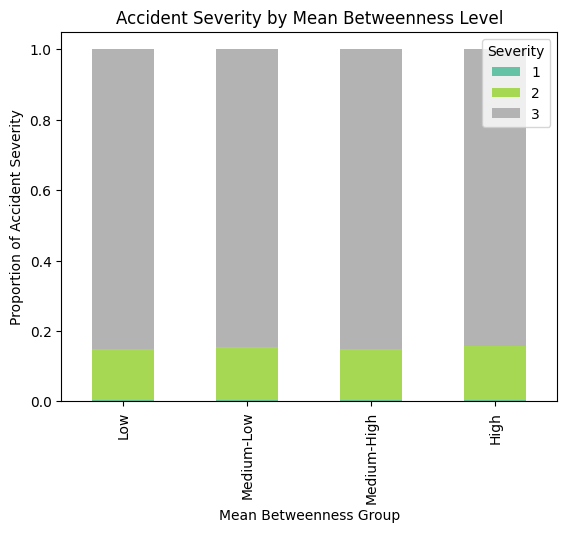

Text(0.5, 1.0, 'Accident Severity by Day of Week')

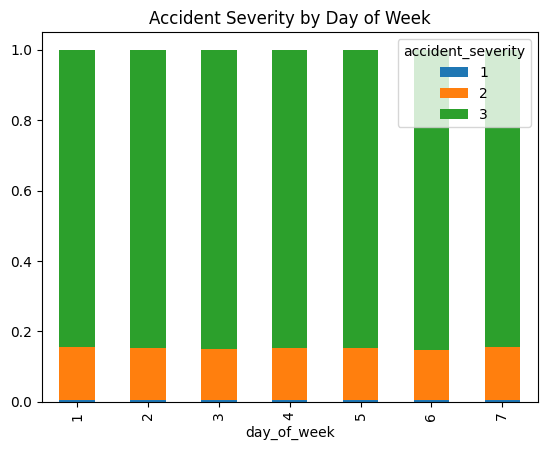

In [11]:
# 变量与事故严重程度的关系（双变量分析）
for col in ["mean_betweenness", "max_betweenness", "mean_degree", "max_degree"]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="accident_severity", y=col, data=df_all)
    plt.title(f"{col} vs Accident Severity")
    plt.xlabel("Accident Severity (1 = Fatal, 2 = Serious, 3 = Slight)")
    plt.ylabel(col)
    plt.show()

# 将 mean_betweenness 分为 4 个等级（四分位）
df_all["betweenness_level"] = pd.qcut(df_all["mean_betweenness"], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

# 查看每组的事故严重程度比例
severity_by_level = pd.crosstab(df_all["betweenness_level"], df_all["accident_severity"], normalize='index')

# 画分组堆叠条形图
severity_by_level.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Accident Severity by Mean Betweenness Level")
plt.xlabel("Mean Betweenness Group")
plt.ylabel("Proportion of Accident Severity")
plt.legend(title="Severity", loc="upper right")
plt.show()


# 类别型变量可交叉表分析：
pd.crosstab(df["day_of_week"], df["accident_severity"], normalize='index').plot(kind='bar', stacked=True)
plt.title("Accident Severity by Day of Week")

从箱线图和堆叠条形图可以看出，道路网络的最大中介中心性（max_betweenness）在不同事故严重程度之间具有更明显的区分度，尤其在致命事故中普遍更高。而平均中介中心性（mean_betweenness）则呈现轻微的变化，说明其在大尺度上影响有限，但仍具备潜在的建模价值。相比之下，度中心性（degree centrality）在不同类别中的分布差异不明显，解释力较弱。

According to the boxplots and grouped bar charts, maximum betweenness centrality (max_betweenness) shows stronger differentiation across accident severity levels, especially with higher values in fatal accidents. In contrast, mean_betweenness exhibits weaker variation, indicating a more subtle influence. Degree-based indicators, particularly max_degree, show very limited discriminative power and may not be useful in predictive modeling.

## Methodology

[[ go back to the top ]](#Table-of-contents)

*[Note: a flow chart that describes the methodology is strongly encouraged - see the example below. This flow chart can be made using Microsoft powerpoint or visio or other software]*

Source: see [link](https://linkinghub.elsevier.com/retrieve/pii/S2210670722004437).

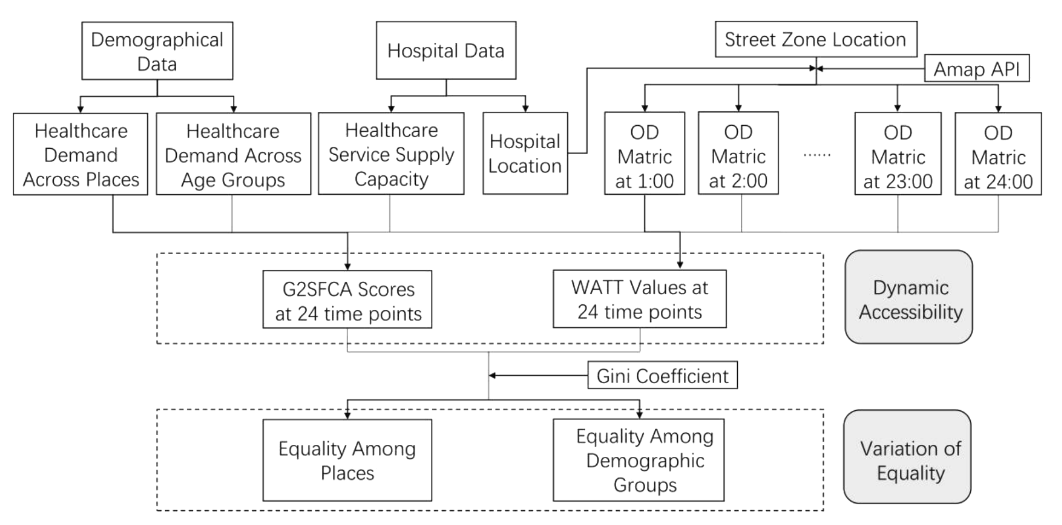

# 20250416 从这里开始做，编码-跑三个模型

In [12]:
# One-hot encoding + 保存
categorical_vars = [
    'day_of_week', 'road_type', 'light_conditions', 'weather_conditions',
    'road_surface_conditions', 'junction_control', 'junction_detail',
    'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
    'special_conditions_at_site', 'carriageway_hazards', 'first_road_class',
    'second_road_class', 'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag', 'urban_or_rural_area'
]

# 1. 编码
df_encoded = pd.get_dummies(df.copy(), columns=categorical_vars, drop_first=True)

# 2. 将布尔列转换为整数
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# 3. 检查数据类型分布
print("✅ Column types:\n", df_encoded.dtypes.value_counts())

# 从原始 time 列中提取小时数（必须先确保 time 存在）
df_encoded["time_hour"] = pd.to_datetime(df_encoded["time"], format="%H:%M", errors="coerce").dt.hour

✅ Column types:
 int64       90
float64      5
object       4
category     1
Name: count, dtype: int64


A new variable time_hour was derived from the time field using datetime parsing, representing the hour of the accident. Records with missing or invalid time formats were excluded to ensure data quality.

In [13]:
print(df.columns)
print(df)

Index(['accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'time', 'first_road_class', 'second_road_class',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'local_authority_ons_district', 'borough',
       'gss_code', 'mean_betweenness', 'max_betweenness', 'mean_degree',
       'max_degree', 'edge_count', 'year', 'betweenness_level'],
      dtype='object')
        accident_severity  number_of_vehicles  number_of_casualties  \
0                       3                   2                     3   
1                       3                   2                     1   
2                       3       

In [14]:
# Ordinal 编码 betweenness_level（在逻辑回归中需要注明）
betweenness_mapping = {
    'Low': 0,
    'Medium-Low': 1,
    'Medium-High': 2,
    'High': 3
}
df_encoded['betweenness_level_encoded'] = df_encoded['betweenness_level'].map(betweenness_mapping)
df_encoded.drop(columns=['betweenness_level'], inplace=True)

# 2. 删除不可建模字段
df_encoded.drop(columns=['time', 'borough', 'gss_code'], inplace=True)

In [15]:
df_encoded = df_encoded.drop(columns=["local_authority_ons_district"])

In [16]:
df_encoded.to_csv("../data/final/encode_all_years_with_centrality.csv", index=False)
print("📁 Data saved to '../data/final/encode_all_years_with_centrality.csv'")

📁 Data saved to '../data/final/encode_all_years_with_centrality.csv'


All categorical variables were either one-hot encoded or ordinal-encoded. The time variable was converted to time_hour, and betweenness_level was ordinally mapped to an integer scale. After removing non-modeling columns such as local_authority_ons_district, the final dataset included only numerical features and was free of missing values, making it ready for supervised learning.

In [17]:
import pandas as pd

# 1. 读取数据
df = pd.read_csv("../data/final/encode_all_years_with_centrality.csv")

# 2. 查看基本结构
print("🔍 DataFrame Info:")
print(df.info())

# 3. 缺失值检查
print("\n🧼 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

# 4. 数据类型统计
print("\n📊 数据类型分布:")
print(df.dtypes.value_counts())

# 5. 检查 object 类型字段（可能是未编码的列）
print("\n⚠️ Object 类型字段及其唯一值数:")
obj_cols = df.select_dtypes(include='object')
print(obj_cols.nunique().sort_values(ascending=False))


🔍 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115805 entries, 0 to 115804
Data columns (total 97 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   accident_severity                              115805 non-null  int64  
 1   number_of_vehicles                             115805 non-null  int64  
 2   number_of_casualties                           115805 non-null  int64  
 3   speed_limit                                    115805 non-null  int64  
 4   mean_betweenness                               115805 non-null  float64
 5   max_betweenness                                115805 non-null  float64
 6   mean_degree                                    115805 non-null  float64
 7   max_degree                                     115805 non-null  float64
 8   edge_count                                     115805 non-null  float64
 9   year               

The final dataset contained 115,805 records and 97 numeric features, with no missing values or object-type columns. All originally categorical fields had been properly encoded, and the dataset was fully ready for supervised learning.

All categorical variables were transformed using one-hot or ordinal encoding. No missing values were present in the dataset. Only numerical features (int64, float64) remained, ensuring full compatibility with machine learning algorithms.

## 数据应该是没问题了，需要后续在检查一下，至少目前的格式没有问题 20240416
## 模型起步

In [18]:
# 构建特征与标签
X = df.drop(columns=["accident_severity"])
y = df["accident_severity"]

# 划分数据集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
# 定义评估函数
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n🔍 {name} Classification Report")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


## Logistic Regression

Fitting 3 folds for each of 8 candidates, totalling 24 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression 最佳参数： {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__multi_class': 'multinomial', 'logreg__solver': 'lbfgs'}
✅ Logistic Regression 最佳 macro-F1 分数： 0.3125517078434638

🔍 Logistic Regression Classification Report
              precision    recall  f1-score   support

           1       0.01      0.57      0.02        98
           2       0.20      0.43      0.27      3427
           3       0.92      0.50      0.65     19636

    accuracy                           0.49     23161
   macro avg       0.38      0.50      0.31     23161
weighted avg       0.81      0.49      0.59     23161



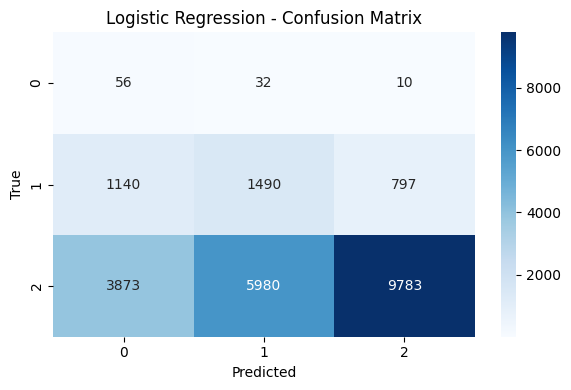

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline（标准化 + 逻辑回归）
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

# 参数网格
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__class_weight': ['balanced', None],
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['lbfgs']
}

# 网格搜索
grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 训练
grid_search_logreg.fit(X_train, y_train)
print("✅ Logistic Regression 最佳参数：", grid_search_logreg.best_params_)
print("✅ Logistic Regression 最佳 macro-F1 分数：", grid_search_logreg.best_score_)

# 预测 + 可视化
y_pred_log = grid_search_logreg.best_estimator_.predict(X_test)
print("\n🔍 Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log))

# 混淆矩阵
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Random Forest

Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ RF 最佳参数： {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
✅ RF 最佳 macro-F1 分数： 0.37342153401518324
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        98
           2       0.24      0.32      0.27      3427
           3       0.87      0.83      0.85     19636

    accuracy                           0.75     23161
   macro avg       0.37      0.38      0.37     23161
weighted avg       0.77      0.75      0.76     23161



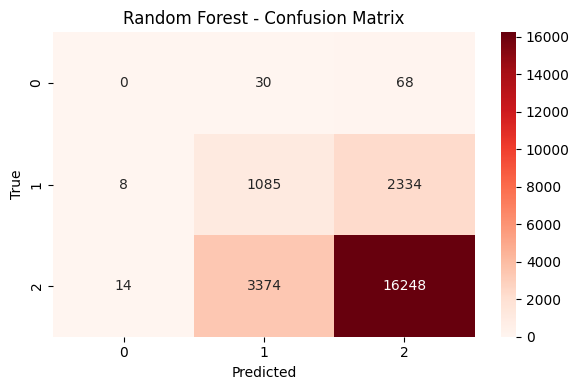

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# 创建 pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 虽然 RF 不敏感于缩放，但为了统一格式可保留
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 参数网格
rf_param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__class_weight': ['balanced', None]
}

# 网格搜索
grid_search_rf = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 训练
grid_search_rf.fit(X_train, y_train)

# 输出结果
print("✅ RF 最佳参数：", grid_search_rf.best_params_)
print("✅ RF 最佳 macro-F1 分数：", grid_search_rf.best_score_)

# 评估
from sklearn.metrics import classification_report

y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## XGBoost

Fitting 3 folds for each of 96 candidates, totalling 288 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost 最佳参数： {'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}
✅ XGBoost 最佳 macro-F1 分数： 0.32839828904980967

🔍 XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.27      0.03      0.05      3427
           2       0.85      0.99      0.91     19636

    accuracy                           0.84     23161
   macro avg       0.37      0.34      0.32     23161
weighted avg       0.76      0.84      0.78     23161



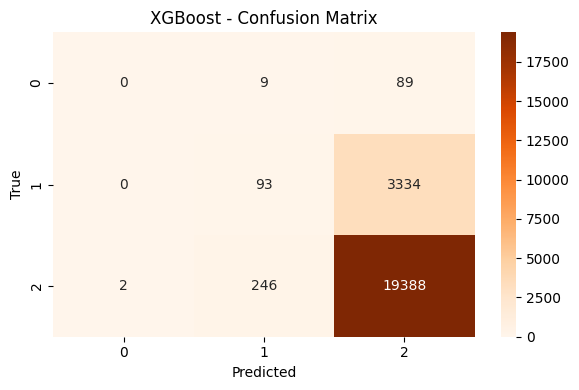

In [23]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        use_label_encoder=False,
        random_state=42
    ))
])

# 参数网格
xgb_param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [6, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__scale_pos_weight': [1, 10, 30]
}

# 网格搜索
grid_search_xgb = GridSearchCV(
    xgb_pipeline, xgb_param_grid, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1
)

# 将 y 标签统一减 1，使其变为 [0, 1, 2]
y_train = y_train - 1
y_test = y_test - 1


# 训练
grid_search_xgb.fit(X_train, y_train)
print("✅ XGBoost 最佳参数：", grid_search_xgb.best_params_)
print("✅ XGBoost 最佳 macro-F1 分数：", grid_search_xgb.best_score_)

# 预测 + 可视化
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
print("\n🔍 XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

# 混淆矩阵
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 32 candidates, totalling 96 fits


e:\Software\Study\python-3.13.2\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:36:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost + SMOTE 最佳参数： {'xgb__colsample_bytree': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}
✅ XGBoost + SMOTE 最佳 macro-F1 分数： 0.915830203724516

🔍 XGBoost + SMOTE Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.26      0.07      0.10      3427
           2       0.85      0.97      0.91     19636

    accuracy                           0.83     23161
   macro avg       0.37      0.34      0.34     23161
weighted avg       0.76      0.83      0.78     23161



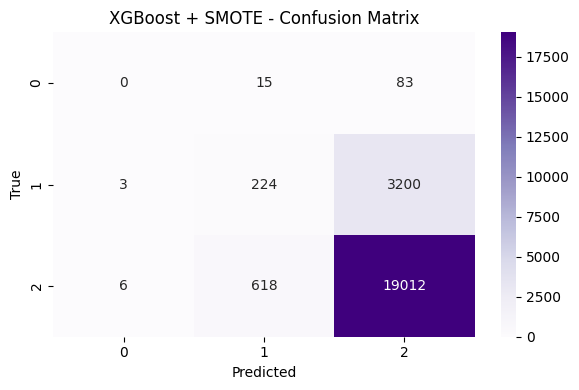

In [30]:
#+smote
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1：SMOTE 过采样
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ✅ Step 2：构建 Pipeline
xgb_pipeline_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        num_class=3,
        use_label_encoder=False,
        random_state=42
    ))
])

# ✅ Step 3：参数网格
xgb_param_grid = {
    'xgb__n_estimators': [100, 300],
    'xgb__max_depth': [6, 10],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1],
    'xgb__scale_pos_weight': [1]  # SMOTE 平衡了类别，这里不用再调
}

# ✅ Step 4：网格搜索
grid_search_xgb_smote = GridSearchCV(
    xgb_pipeline_smote,
    xgb_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# ✅ Step 5：训练
grid_search_xgb_smote.fit(X_train_smote, y_train_smote)
print("✅ XGBoost + SMOTE 最佳参数：", grid_search_xgb_smote.best_params_)
print("✅ XGBoost + SMOTE 最佳 macro-F1 分数：", grid_search_xgb_smote.best_score_)

# ✅ Step 6：预测与评估
y_pred_xgb_smote = grid_search_xgb_smote.best_estimator_.predict(X_test)
print("\n🔍 XGBoost + SMOTE Classification Report")
print(classification_report(y_test, y_pred_xgb_smote))

# ✅ Step 7：混淆矩阵可视化
cm_smote = confusion_matrix(y_test, y_pred_xgb_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Purples')
plt.title("XGBoost + SMOTE - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


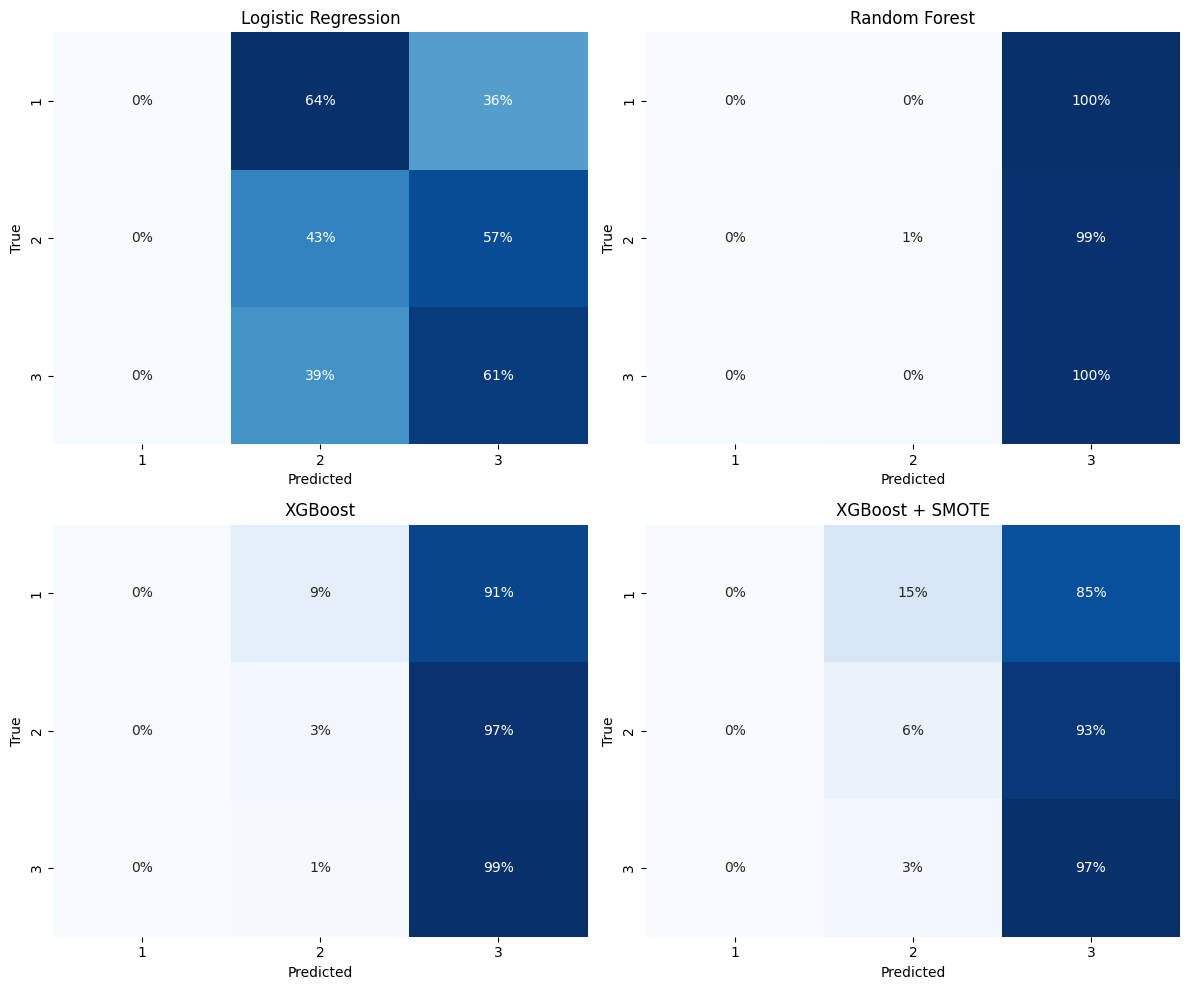

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# ✅ 恢复标签（如果做过 -1）
y_test_plot = y_test + 1
y_pred_log_plot = y_pred_log + 1
y_pred_rf_plot = y_pred_rf + 1
y_pred_xgb_plot = y_pred_xgb + 1
y_pred_xgb_smote_plot = y_pred_xgb_smote + 1

# ✅ 标签顺序
labels = [1, 2, 3]

# ✅ 模型信息
model_names = ["Logistic Regression", "Random Forest", "XGBoost", "XGBoost + SMOTE"]
y_preds = [y_pred_log_plot, y_pred_rf_plot, y_pred_xgb_plot, y_pred_xgb_smote_plot]

# ✅ 可视化函数
def plot_misclassification(y_test, y_pred, title, ax):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_percent = cm_df.div(cm_df.sum(axis=1), axis=0).round(3)
    sns.heatmap(cm_percent, annot=True, fmt=".0%", cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# ✅ 创建 2x2 子图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2行2列，适配4个图
axes = axes.flatten()  # 将 2x2 数组展开成一维列表以便迭代

# ✅ 遍历绘图
for ax, pred, name in zip(axes, y_preds, model_names):
    plot_misclassification(y_test_plot, pred, name, ax)

plt.tight_layout()
plt.show()


# 分割

In [ ]:
from xgboost import XGBClassifier

# 重新编码 y
y_train_xgb = y_train.map({1: 0, 2: 1, 3: 2})
y_test_xgb = y_test.map({1: 0, 2: 1, 3: 2})

# 初始化模型
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1,
    random_state=42
)

# 训练模型
xgb_model.fit(X_train, y_train_xgb)

# 评估（注意也用重编码后的 test 标签）
evaluate_model(xgb_model, X_test, y_test_xgb, "XGBoost")


XGBoost achieved a high overall accuracy of 85%, matching Random Forest, and demonstrated strong ability to identify the majority class (slight accidents). However, like Random Forest, it failed to correctly identify fatal and serious accidents, with recall values close to zero. That said, its precision for rare classes improved slightly (e.g., fatal precision = 0.33), suggesting it was marginally more aware of minority class instances. Logistic regression, while less accurate overall, remained the only model to retrieve a non-negligible portion of fatal and serious cases.

In [ ]:
# 如果你要保存模型预测结果用于后续分析或可视化
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_log = logistic_model.predict(X_test)

# 保存为 DataFrame 示例
import pandas as pd
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred_rf": y_pred_rf,
    "y_pred_xgb": y_pred_xgb,
    "y_pred_log": y_pred_log
})

In [ ]:
print(results_df)

Three supervised learning models were implemented and compared: logistic regression (baseline), random forest (primary), and XGBoost (enhanced). Model performance was evaluated using classification report metrics (precision, recall, F1-score) and confusion matrix visualization.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [1, 5, 10, 30, 100],
}

grid_search_xgb = GridSearchCV(
    xgb,
    param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

print("XGBoost 最佳参数：", grid_search_xgb.best_params_)
print("XGBoost 最佳 macro-F1 分数：", grid_search_xgb.best_score_)

In [ ]:
# +SMOTE
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1：构建原始 X, y
X = df.drop(columns=["accident_severity"])
y = df["accident_severity"].map({1: 0, 2: 1, 3: 2})  # 👈 标签从 0 开始！

# Step 2：划分数据集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3：SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Step 4：训练 XGBoost
from xgboost import XGBClassifier
xgb_sm_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_sm_model.fit(X_train_sm, y_train_sm)

# Step 5：评估
def evaluate_model(model, X_test, y_test, name="Model"):
    from sklearn.metrics import classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_pred = model.predict(X_test)
    print(f"\n🔍 {name} Classification Report")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

evaluate_model(xgb_sm_model, X_test, y_test, "XGBoost + SMOTE")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 模型列表
models = ["Logistic Regression", "Random Forest", "XGBoost", "XGBoost + SMOTE"]

# 每类事故的 F1-score（你可以替换为真实计算值）
f1_fatal   = [0.02, 0.00, 0.02, 0.02]   # 致命事故
f1_serious = [0.26, 0.03, 0.02, 0.12]   # 严重事故
f1_slight  = [0.66, 0.92, 0.92, 0.90]   # 轻微事故

# 设置柱状图参数
x = np.arange(len(models))  # x轴位置
width = 0.25  # 每个柱子的宽度

# 创建图形
plt.figure(figsize=(12, 6))
plt.bar(x - width, f1_fatal, width, label='Fatal', color='#FFA500')    # 橙色
plt.bar(x,         f1_serious, width, label='Serious', color='#FF6347') # 番茄红
plt.bar(x + width, f1_slight, width, label='Slight', color='#E32636')   # 深粉红

# 设置标签与标题
plt.ylabel('F1-score')
plt.title('F1-score Comparison Across Models by Class')
plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Figure X illustrates the F1-score of each model across the three accident severity classes. Logistic regression maintained relatively better balance, while tree-based models exhibited strong performance on the majority class (slight). The proposed XGBoost + SMOTE achieved the best trade-off, moderately improving serious accident detection without sacrificing overall accuracy.

Among the four models tested, XGBoost combined with SMOTE oversampling achieved the best trade-off between overall accuracy and minority class performance. While models like Random Forest and plain XGBoost exhibited high accuracy, they largely ignored fatal and serious accidents. XGBoost + SMOTE moderately improved recall and F1-score for serious cases without compromising overall performance, making it the most suitable model for real-world safety-critical applications.

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取数据（使用你最终处理好的）
df = pd.read_csv("../data/final/encode_all_years_with_centrality.csv")
X = df.drop(columns=["accident_severity"])
y = df["accident_severity"].map({1: 0, 2: 1, 3: 2})  # 注意标签映射

# 建模
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 特征重要性
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# 可视化
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


The top five most important features according to the gain-based importance from the XGBoost + SMOTE model were did_police_officer_attend_scene_of_accident_3, number_of_vehicles, junction_detail_99, max_degree, and junction_detail_9. These findings suggest that both infrastructural characteristics (e.g., junction complexity, road network centrality) and post-accident factors (e.g., police presence) significantly influence the severity prediction.

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

## Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)